<a href="https://colab.research.google.com/github/acorbe/covid19-analytics-NL-EU/blob/master/Corona_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 epidemic in the Netherlands, an open observatory for quantitative analysis

## Contact: Alessandro Corbetta, Federico Toschi

### Introduction
This Python notebook update itself daily with the latest data from the Netherlands [1] and from all other countries in the world [2]. This page just show data and some very basic fit to the data (i.e. we stick to the [KISS](https://en.wikipedia.org/wiki/KISS_principle) principle). We are physicists, not epidemiologist, and we believe that making this page available can potentially enable anybody interested in making sense of the data and assessing the effect of past and future policies.  

---
#### References

[1] 2019–20 coronavirus pandemic data/Netherlands medical cases, https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Netherlands_medical_cases

[2] European Centre for Disease Prevention and Control
An agency of the European Union, https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide



In [0]:
# importing relevant libraries
import array as arr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## EU Data import

The command below imports all data from ECDC european database


Link: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide 

In [0]:
import pandas as pd
date_to_import = "2020-03-26"

df_orig = pd.read_excel("https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-%s.xlsx" 
                        % date_to_import)

## Initialization

The table is time-sorted and some utility columns are added


In [0]:
df = df_orig.sort_values(by = ['DateRep'])

## Renaming columns for convenience
df['CountryExp'] = df['Countries and territories']
df['NewConfCases'] = df['Cases']
df['NewDeaths'] = df['Deaths']

## Making a time column that start from 0 on 31-12-2019
df['shifted_time'] = df.groupby('CountryExp').NewConfCases.transform(lambda x : np.arange(len(x)))

## cumulative counts
df['cumsum_cases'] = df[['CountryExp', 'shifted_time', 'NewConfCases']].groupby('CountryExp').NewConfCases.cumsum()
df['cumsum_deaths'] = df[['CountryExp', 'shifted_time', 'NewConfCases','NewDeaths']].groupby('CountryExp').NewDeaths.cumsum()

##
df["DateRep"] = pd.to_datetime(df["DateRep"])

## Reduced dataset restricted to cases with at least 99 cases
df_larger_10 = df.query('cumsum_cases > 99').copy()
df_larger_10['shifted_time_new'] = df_larger_10.groupby('CountryExp').NewConfCases.transform(lambda x : np.arange(len(x)))

## Plotting data for one country (The Netherlands)

+ `first_day` counts how many days since the beginning of the dataset (31-12-2019)
+ `which_data` defines which column is plotted. 
     It can be 
     + `"cumsum_cases"`
     + `"cumsum_deaths"`



/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Cumulative counts')

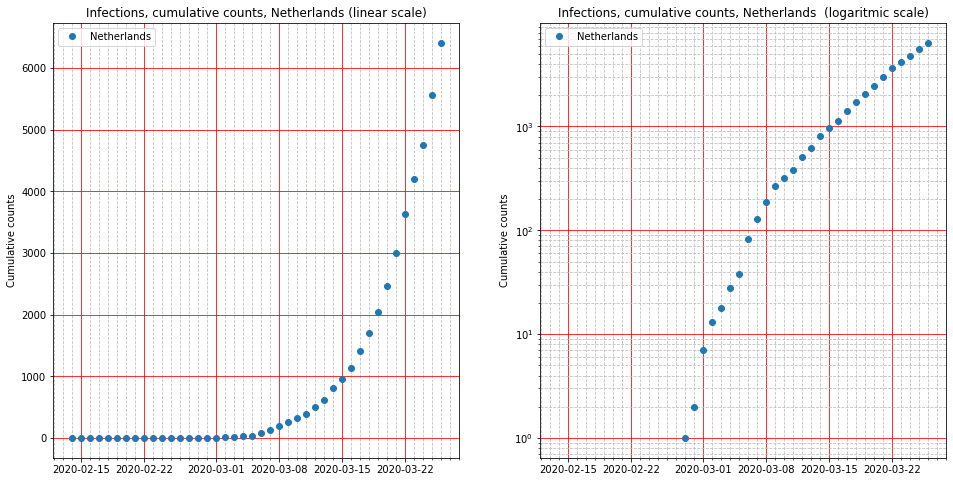

In [4]:
first_day = 45
country = 'Netherlands'
which_data = "cumsum_cases"

one_country = df.query("CountryExp == @country")[first_day:]
plt.figure(figsize=(16,8))

days = mdates.DayLocator()   # every year

## Linear scale
plt.subplot(121)
plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)
plt.title("Infections, cumulative counts, %s (linear scale)" %country)
plt.ylabel("Cumulative counts")
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
plt.legend()
ax = plt.gca()
ax.xaxis.set_minor_locator(days)
#plt.grid()

## Log scale
plt.subplot(122)
plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)
plt.title("Infections, cumulative counts, %s  (logaritmic scale)" %country)
plt.legend()
plt.yscale('log')
ax = plt.gca()
ax.xaxis.set_minor_locator(days)
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
plt.ylabel("Cumulative counts")


## Show data from table


In [5]:
one_country.head()

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId,Country Code,Pop_Data.2018,CountryExp,NewConfCases,NewDeaths,shifted_time,cumsum_cases,cumsum_deaths
4492,2020-02-14,14,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,45,0,0
4491,2020-02-15,15,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,46,0,0
4490,2020-02-16,16,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,47,0,0
4489,2020-02-17,17,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,48,0,0
4488,2020-02-18,18,2,2020,0,0,Netherlands,NL,NLD,17231017.0,Netherlands,0,0,49,0,0


## Comparing multiple countries 
In the following we plot the cumulative sum of cases for
*   The Netherlands
*   Italy
*   Belgium

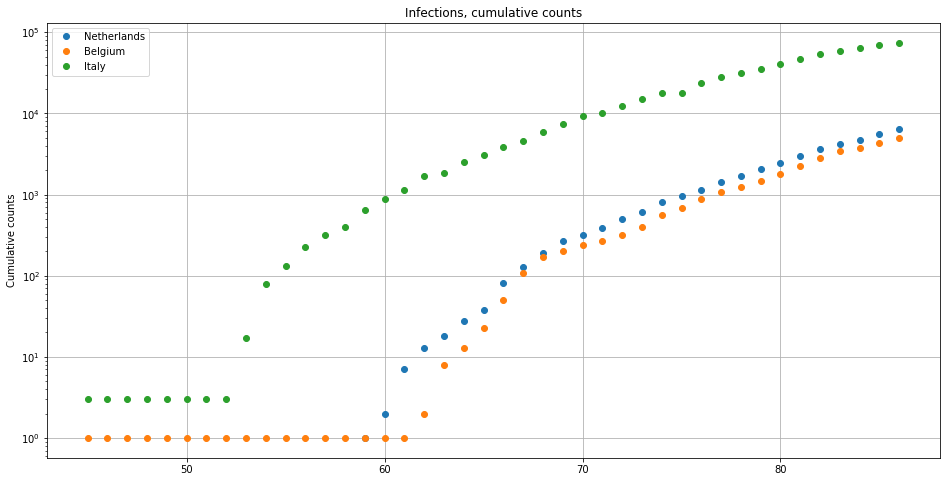

In [6]:
first_day = 45
countries = ['Netherlands','Belgium','Italy']
which_data = "cumsum_cases"
plt.figure(figsize=(16,8))

## plotting data from each country
for country in countries:
  one_country = df.query("CountryExp == @country")[first_day:]
  plt.plot(one_country.shifted_time, one_country["cumsum_cases"],"o",label=country)

plt.ylabel("Cumulative counts")
plt.legend()
plt.grid()
plt.title("Infections, cumulative counts")
plt.yscale('log')




## Data fitting with a simple sigmoid function (logistic model)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log


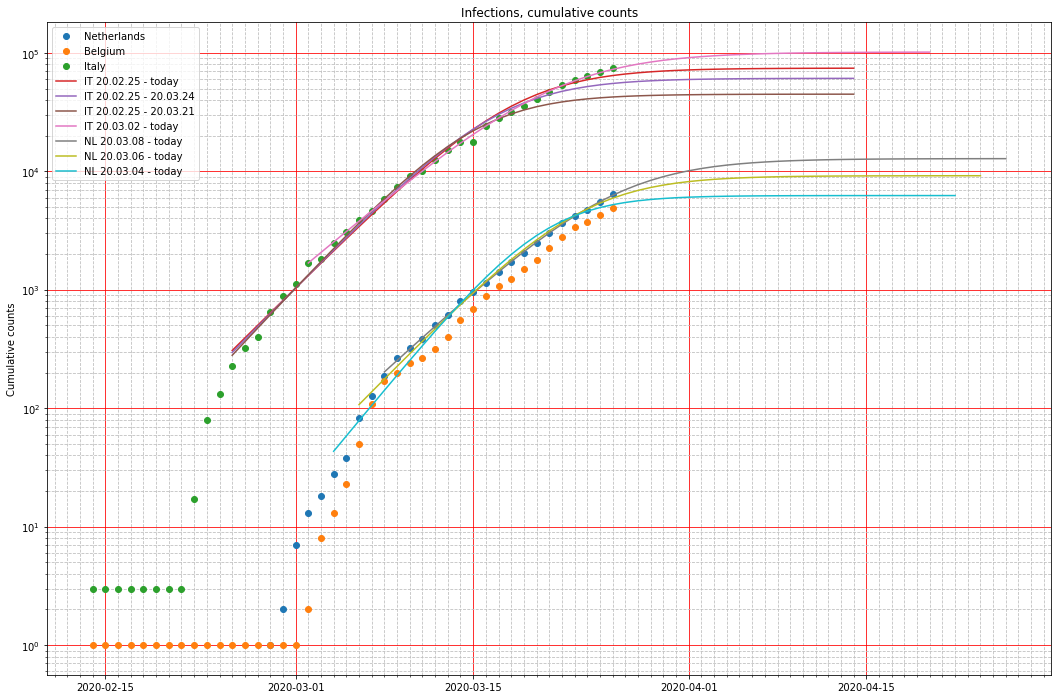

In [7]:
first_day = 45
fit_first_day_it = 56
fit_first_day_nl = 68

countries = ['Netherlands','Belgium','Italy']
which_data = "cumsum_cases"

plt.figure(figsize=(18,12))

for country in countries:
  one_country = df.query("CountryExp == @country")[first_day:]
  plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)

plt.ylabel("Cumulative counts")
plt.legend()
plt.grid()
plt.title("Infections, cumulative counts")
plt.yscale('log')

def flogistic(xx,p,k,r):  
  return p*k / (p + (p-k)*np.exp(-r*xx))

def logflogistic(xx,p,k,r):  
  return np.log(p*k / (p + (p-k)*np.exp(-r*xx)))

def fit_in_interval(one_country_ext,label='log-fit'):
  one_country = one_country_ext
  import scipy.optimize as opt

  ydata =  one_country.cumsum_cases
  integers_ = np.arange(len(one_country.cumsum_cases))

  popt_log, pcov_log = opt.curve_fit( flogistic, integers_ , ydata )

  log_popt_log, log_pcov_log = opt.curve_fit( logflogistic
                                            , integers_ 
                                            , np.log(ydata)
                                            , p0=popt_log)
  days_with_future_int = np.arange(50)  
  days_with_future = pd.Series([pd.Timedelta(days=x) for x in np.arange(50) ])
  
  plt.plot(days_with_future + one_country.DateRep.iloc[0] 
          , np.exp(logflogistic(days_with_future_int, *log_popt_log)), label=label )

it_time_columns = df.query("CountryExp == 'Italy'")[fit_first_day_it:].DateRep.dt.strftime("%y.%m.%d")
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:],label ='IT %s - today' % it_time_columns.iloc[0]) #,0,-1)
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:][:-3],label='IT %s - %s' % (it_time_columns.iloc[0],it_time_columns.iloc[-3]) )
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:][:-6],label='IT %s - %s' % (it_time_columns.iloc[0],it_time_columns.iloc[-6]))
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:][6:],label='IT %s - today' % it_time_columns.iloc[6])


nl_time_columns = df.query("CountryExp == 'Netherlands'").DateRep.dt.strftime("%y.%m.%d")
fit_in_interval(df.query("CountryExp == 'Netherlands'")[fit_first_day_nl:],label='NL %s - today' % nl_time_columns.iloc[fit_first_day_nl])
fit_in_interval(df.query("CountryExp == 'Netherlands'")[fit_first_day_nl-2:],label='NL %s - today' % nl_time_columns.iloc[fit_first_day_nl-2])
fit_in_interval(df.query("CountryExp == 'Netherlands'")[fit_first_day_nl-4:],label='NL %s - today' % nl_time_columns.iloc[fit_first_day_nl-4])

plt.grid()
plt.grid(b=True, which='minor')#, color='r', linestyle='--')
plt.legend()
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
days = mdates.DayLocator()   
ax = plt.gca()
ax.xaxis.set_minor_locator(days)

## Aligning time for different countries (e.g. to check the delay of the epidemic between different countries)

---



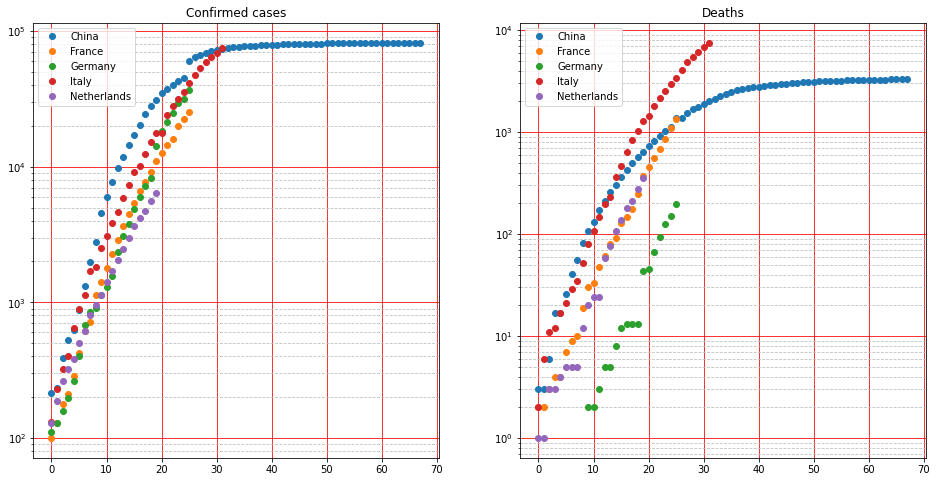

In [8]:
countries = ["Italy", "China", "Netherlands","Germany","France"]

plt.figure(figsize = (16,8))
plt.subplot(121)

#df.query('CountryExp in @countries').groupby('CountryExp').apply(lambda x : plt.plot(x.shifted_time,x.cumsum_cases)) #.cumsum_cases.plot()

for k,v in df_larger_10.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new,v.cumsum_cases,'o',label=k)
plt.title('Confirmed cases')
plt.yscale('log')
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.legend()

plt.subplot(122)
for k,v in df_larger_10.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new,v.cumsum_deaths,'o',label=k)

plt.title('Deaths')
plt.yscale('log')

ax = plt.gca()
#ax.xaxis.set_minor_locator(1)
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.legend()

## Aligning time for different countries, normalizing the counts vs. the population


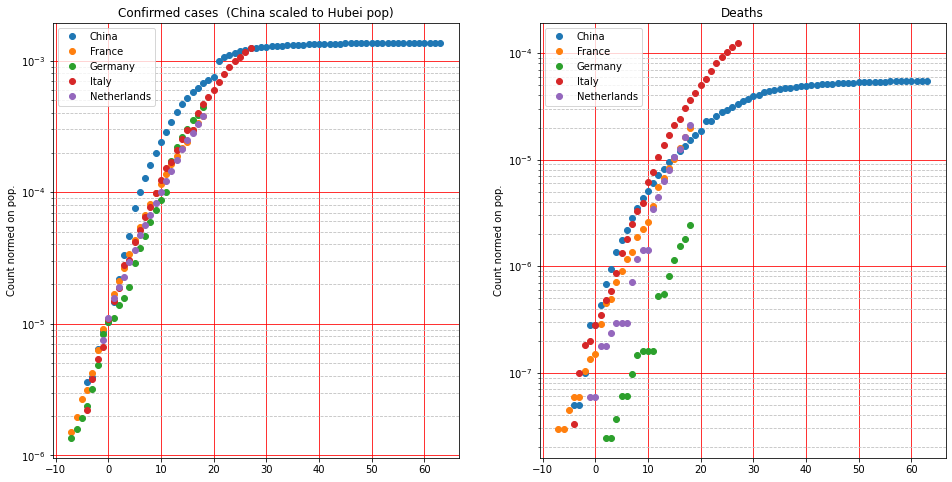

In [9]:
countries = ["Italy", "China", "Netherlands","Germany", "France"]
est_pop = [60e6,  60e6 ,17e6, 82e6,67e6 ]

pop_df = pd.DataFrame({"CountryExp": countries, "population" : est_pop})

df_loc = pd.merge(df_larger_10, pop_df, on='CountryExp')

df_loc['rel_cumsum_cases'] = df_loc.cumsum_cases/df_loc.population
df_loc['rel_cumsum_cases_st_1em5'] = df_loc['rel_cumsum_cases'] < 1e-5
df_loc['conf_rel_gt1em5'] =  df_loc.groupby('CountryExp').rel_cumsum_cases_st_1em5.transform('sum')


plt.figure(figsize = (16,8))
plt.subplot(121)

#df.query('CountryExp in @countries').groupby('CountryExp').apply(lambda x : plt.plot(x.shifted_time,x.cumsum_cases)) #.cumsum_cases.plot()

for k,v in df_loc.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new - v.conf_rel_gt1em5 ,v.cumsum_cases/v.population,'o',label=k)
plt.title('Confirmed cases  (China scaled to Hubei pop)')

plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.ylabel('Count normed on pop.')
plt.yscale('log')
plt.legend()

plt.subplot(122)
for k,v in df_loc.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new - v.conf_rel_gt1em5,v.cumsum_deaths/v.population,'o',label=k)

plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.title('Deaths')
plt.ylabel('Count normed on pop.')
plt.yscale('log')
plt.legend()

# Netherdelands data - from wikipedia

In [0]:
## importing and cleaning data from citations. 
## relevant columns are casted to numbers (float)

my_html_table = "https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Netherlands_medical_cases"

import pandas as pd
A = pd.read_html(my_html_table)

NL_situation = A[0][:-2]


def split_if_necessary(x):
  try:
    value = x.split('[')[0]
  except:
    value = float(x)

  return value

NL_situation_cleaned = NL_situation.applymap(split_if_necessary)
numeric_columns = [ x for  x in NL_situation_cleaned.columns 
                   if x[0] not in ["Date[a]", "Source(s)"] and x[1] not in ["Diff."] ]

NL_situation_cleaned[numeric_columns] = NL_situation_cleaned[numeric_columns].astype(float)
# converting dates
NL_situation_cleaned[("Date[a]","Date[a]")] = pd.to_datetime(NL_situation_cleaned["Date[a]"]["Date[a]"])

NL_situation_cleaned = NL_situation_cleaned.set_index(NL_situation_cleaned[("Date[a]","Date[a]")])
NL_situation_cleaned.index.rename("Date",inplace=True)


## Data by province

In [60]:
NL_situation_cleaned["Province"]

,NB,NH,ZH,DR,UT,GD,FL,OV,LB,ZL,FR,GR,Unk.
Date,,,,,,,,,,,,,
2020-02-27,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,4.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-04,5.0,4.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-05,7.0,2.0,5.0,1.0,20.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,4.0
2020-03-06,10.0,1.0,10.0,NaN,10.0,8.0,1.0,NaN,7.0,NaN,NaN,NaN,-1.0


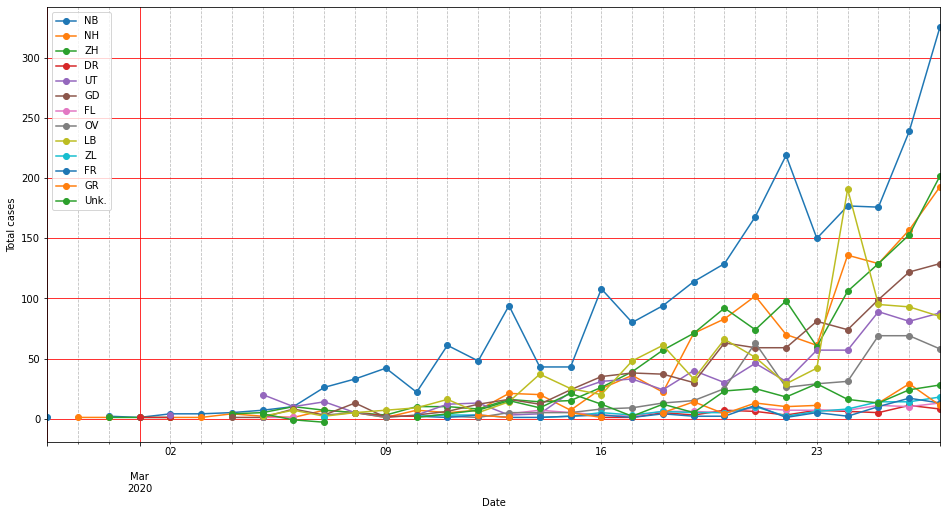

In [61]:
plt.figure(figsize=(16,8))
ax = plt.gca()
NL_situation_cleaned['Province'].plot(marker='o',ax = ax)
plt.ylabel("Total cases")

plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

days = mdates.DayLocator()   
ax = plt.gca()
ax.xaxis.set_minor_locator(days)

(737482.0, 737521.0)

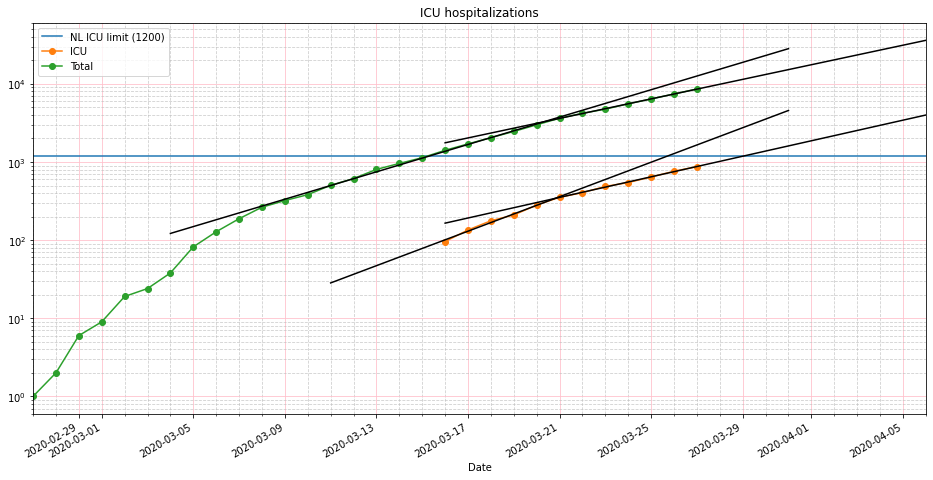

In [69]:
## ICU Patients
NL_ICU_LIMIT = 1200


plt.figure(figsize=(16,8))
ax = plt.gca()

total_cases = NL_situation_cleaned['Cases[b]']['Total']
icu_cases = NL_situation_cleaned['Hospitalizations']['ICU']
timespan = [NL_situation_cleaned.index[0]
            , NL_situation_cleaned.index[-1]]


extended_timespan = [NL_situation_cleaned.index[0]
            , NL_situation_cleaned.index[-1] + pd.Timedelta(days = 10)]



plt.plot(extended_timespan,[NL_ICU_LIMIT,NL_ICU_LIMIT]
         ,label="NL ICU limit (1200)")

icu_cases.plot(marker='o',ax = ax)
total_cases.plot(marker='o',ax = ax)

def exp_fit_portion(ydata_all
                    ,extend_fit_days = 10
                    ,extend_fit_days_before = 5
                    ,plot_kw = {}):  
  ydata = ydata_all.values
  xdata = np.arange(len(ydata))
  xdata_extended = np.arange(-extend_fit_days_before, len(ydata) + extend_fit_days)
  xdata_idx = ydata_all.index
  logy = np.log(ydata)
  ret = np.polyfit(xdata,logy,1)  
  fit_y = np.exp(np.polyval(ret,xdata_extended))
  
  xdata_idx_extended = [xdata_idx[0] + pd.Timedelta(days = x - extend_fit_days_before) 
                          for x in range(len(xdata_idx) + extend_fit_days + extend_fit_days_before)]
  plt.plot(xdata_idx_extended,fit_y,**plot_kw)

exp_fit_portion(total_cases["09-Mar-2020":"21-Mar-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})
exp_fit_portion(total_cases["21-Mar-2020":"28-Mar-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})


exp_fit_portion(icu_cases["16-Mar-2020":"21-Mar-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})
exp_fit_portion(icu_cases["21-Mar-2020":"28-Mar-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})


plt.legend()
plt.yscale('log')
plt.title('ICU hospitalizations')

plt.grid(b=True, which='minor', color='0.75', alpha=0.75, linestyle='--')
plt.grid(b=True, which='major', color='pink', alpha=1,linestyle='-')

days = mdates.DayLocator()   
ax = plt.gca()
ax.xaxis.set_minor_locator(days)

plt.xlim([timespan[0],timespan[1] + pd.Timedelta(days=10)])


In [28]:
total_cases["09-Mar-2020":"21-Mar-2020"]

(Date[a], Date[a])
2020-03-09     321.0
2020-03-10     382.0
2020-03-11     503.0
2020-03-12     614.0
2020-03-13     804.0
2020-03-14     959.0
2020-03-15    1135.0
2020-03-16    1413.0
2020-03-17    1705.0
2020-03-18    2051.0
2020-03-19    2460.0
2020-03-20    2994.0
2020-03-21    3631.0
Name: Total, dtype: float64